In [16]:
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import tensorflow as tf

In [2]:
import os
# Find the latest version of spark 3.0  from http://www.apache.org/dist/spark/ and enter as the spark version
# For example:
# spark_version = 'spark-3.0.3'
spark_version = 'spark-3.2.0'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop2.7.tgz
!tar xf $SPARK_VERSION-bin-hadoop2.7.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop2.7"

# Start a SparkSession
import findspark
findspark.init()

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Get:4 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://archive.ubuntu.com/ubuntu bionic-backpor

In [3]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("sparkFunctions").getOrCreate()

In [5]:
from pyspark import SparkFiles
url ="https://yelpproject4.s3.amazonaws.com/yelp_restaurants.csv"
spark.sparkContext.addFile(url)
df = spark.read.csv(SparkFiles.get("yelp_restaurants.csv"), sep=",", header=True)

# Show DataFrame
df.show()

+--------------------+--------------------+--------------------+-----------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+
|         business_id|                name|             address|       city|state|postal_code|     latitude|      longitude|stars|review_count|is_open|          attributes|          categories|               hours|
+--------------------+--------------------+--------------------+-----------+-----+-----------+-------------+---------------+-----+------------+-------+--------------------+--------------------+--------------------+
|6iYb2HFDywm3zjuRg...| Oskar Blues Taproom|        921 Pearl St|    Boulder|   CO|      80302|   40.0175444|   -105.2833481|  4.0|          86|      1|"{'RestaurantsTab...| 'BikeParking': '...| 'BusinessParking...|
|tCbdrRPZA0oiIYSmH...|Flying Elephants ...| 7000 NE Airport Way|   Portland|   OR|      97218|45.5889058992|-122.5933307507|  4.0|         1

In [6]:
df1= df.select(["review_count","categories", "state", "stars"])

In [7]:
yelp = df1.toPandas()
yelp

,review_count,categories,state,stars
0,86,'BikeParking': 'True',CO,4.0
1,126,'GoodForKids': 'True',OR,4.0
2,169,'RestaurantsGoodForGroups': 'True',BC,3.5
3,11,"Breakfast & Brunch, Restaurants",OH,4.5
4,39,'intimate': False,MA,4.0
...,...,...,...,...
32017,733,"'WiFi': """"u'no'""""",MA,5.0
32018,437,"'RestaurantsAttire': """"'casual'""""",FL,4.5
32019,310,'street': False,TX,3.0
32020,185,'BusinessAcceptsCreditCards': 'True',GA,3.0


In [8]:
yelp['stars']= yelp['stars'].astype(float)

In [9]:
def ycolumn(x):
  stars = x['stars']
  if stars >= 3:
    return 1
  else:
    return 0
yelp['Stars Y'] = yelp.apply(lambda x: ycolumn(x),axis=1)

In [10]:
yelp['Stars Y']

0        1
1        1
2        1
3        1
4        1
        ..
32017    1
32018    1
32019    1
32020    1
32021    1
Name: Stars Y, Length: 32022, dtype: int64

In [11]:
yelp['review_count'] = yelp['review_count'].astype(int)

In [12]:
X= yelp.drop(["stars", "Stars Y"], axis =1)

X

,review_count,categories,state
0,86,'BikeParking': 'True',CO
1,126,'GoodForKids': 'True',OR
2,169,'RestaurantsGoodForGroups': 'True',BC
3,11,"Breakfast & Brunch, Restaurants",OH
4,39,'intimate': False,MA
...,...,...,...
32017,733,"'WiFi': """"u'no'""""",MA
32018,437,"'RestaurantsAttire': """"'casual'""""",FL
32019,310,'street': False,TX
32020,185,'BusinessAcceptsCreditCards': 'True',GA


In [13]:
X_dummies = pd.get_dummies(X)
X_dummies

,review_count,categories_ 'AcceptsInsurance': 'True',"categories_ 'Alcohol': """"'beer_and_wine'""""","categories_ 'Alcohol': """"'full_bar'""""","categories_ 'Alcohol': """"'none'""""","categories_ 'Alcohol': """"u'beer_and_wine'""""","categories_ 'Alcohol': """"u'full_bar'""""","categories_ 'Alcohol': """"u'none'""""","categories_ 'Alcohol': """"u'none'""""}""","categories_ 'Ambience': """"{'hipster': False","categories_ 'Ambience': """"{'romantic': False","categories_ 'Ambience': """"{'touristy': False","categories_ 'Ambience': """"{'touristy': None","categories_ 'Ambience': """"{'touristy': True",categories_ 'Ambience': 'None',categories_ 'BYOB': 'False',categories_ 'BYOB': 'True',"categories_ 'BYOBCorkage': """"'no'""""","categories_ 'BYOBCorkage': """"'yes_corkage'""""","categories_ 'BYOBCorkage': """"'yes_free'""""","categories_ 'BestNights': """"{'monday': False","categories_ 'BestNights': """"{'monday': True",categories_ 'BikeParking': 'False',categories_ 'BikeParking': 'True',categories_ 'BusinessAcceptsBitcoin': 'False',categories_ 'BusinessAcceptsCreditCards': 'False',categories_ 'BusinessAcceptsCreditCards': 'True',"categories_ 'BusinessAcceptsCreditCards': 'True'}""","categories_ 'BusinessParking': """"{'garage': False","categories_ 'BusinessParking': """"{'garage': None","categories_ 'BusinessParking': """"{'garage': True","categories_ 'BusinessParking': """"{'valet': False",categories_ 'BusinessParking': 'None',categories_ 'ByAppointmentOnly': 'False',categories_ 'ByAppointmentOnly': 'True',categories_ 'Caters': 'False',"categories_ 'Caters': 'False'}""",categories_ 'Caters': 'True',"categories_ 'Caters': 'True'}""",categories_ 'CoatCheck': 'False',...,"categories_Vegetarian, Juice Bars & Smoothies, Vegan, Restaurants, Food, Latin American","categories_Vegetarian, Restaurants","categories_Vegetarian, Restaurants, Salad, Ice Cream & Frozen Yogurt, Food, Juice Bars & Smoothies, Fast Food","categories_Vegetarian, Vegan, Restaurants","categories_Vegetarian, Vegan, Salad, Restaurants","categories_Venues & Event Spaces, Chinese, Wedding Planning, Restaurants, Event Planning & Services","categories_Venues & Event Spaces, Cinema, Event Planning & Services, Arts & Entertainment, Restaurants, American (New)","categories_Venues & Event Spaces, Nightlife, Comfort Food, Hotels, Event Planning & Services, Restaurants, Bars, Hotels & Travel","categories_Venues & Event Spaces, Social Clubs, Arts & Entertainment, Restaurants, Event Planning & Services","categories_Vietnamese, Restaurants","categories_Vietnamese, Restaurants, Gluten-Free, Vegetarian","categories_Vietnamese, Soup, Restaurants, Noodles","categories_Waffles, Food, Bubble Tea, Hot Pot, Restaurants","categories_Waffles, Food, Cafes, Themed Cafes, Coffee & Tea, Restaurants","categories_Waffles, Food, Restaurants, Creperies, Acai Bowls","categories_Waffles, Taiwanese, Restaurants","categories_Wedding Planning, Event Planning & Services, Education, Restaurants, Social Clubs, Arts & Entertainment, American (New), Colleges & Universities, Venues & Event Spaces","categories_Wedding Planning, Event Planning & Services, Venues & Event Spaces, Caterers, Restaurants","categories_Wine Bars, Bars, Food, Bubble Tea, Restaurants, Nightlife, Steakhouses, Seafood, Asian Fusion","categories_Wine Bars, Nightlife, Cocktail Bars, Mexican, Bars, Vegan, Tacos, Restaurants","categories_Wine Bars, Pizza, Beer Bar, Bars, Restaurants, Nightlife","categories_Wine Tasting Room, Tapas/Small Plates, Nightlife, Restaurants, American (New), Wine Bars, Bars, Wineries, Food, Arts & Entertainment","categories_Wraps, Restaurants, Soup, Salad","categories_Wraps, Salad, Greek, Restaurants",state_ABE,state_BC,state_CO,state_FL,state_GA,state_KS,state_KY,state_MA,state_MN,state_NH,state_OH,state_OR,state_TX,state_VA,state_WA,state_WY
0,86,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0
1,126,0,

In [14]:
# Assign the data to X and y

y = yelp['Stars Y']

In [15]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_dummies, y, random_state=42)

In [17]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [46]:
# Create the Keras Sequential model
nn_model = tf.keras.models.Sequential()

In [47]:
# Add our first Dense layer, including the input layer
nn_model.add(tf.keras.layers.Dense(units=1, activation="relu", input_dim=1266))

In [48]:
# Add the output layer that uses a probability activation function
nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

In [49]:
# Check the structure of the Sequential model
nn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 1)                 1267      
                                                                 
 dense_8 (Dense)             (None, 1)                 2         
                                                                 
Total params: 1,269
Trainable params: 1,269
Non-trainable params: 0
_________________________________________________________________


In [50]:
# Compile the Sequential model together and customize metrics
nn_model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

# Fit the model to the training data
fit_model = nn_model.fit(X_train_scaled, y_train, epochs=100)

Epoch 1/100
751/751 [==============================] - 3s 3ms/step - loss: 0.4626 - accuracy: 0.8364
Epoch 2/100
751/751 [==============================] - 2s 2ms/step - loss: 0.4144 - accuracy: 0.8371
Epoch 3/100
751/751 [==============================] - 2s 3ms/step - loss: 0.3984 - accuracy: 0.8371
Epoch 4/100
751/751 [==============================] - 2s 2ms/step - loss: 0.3927 - accuracy: 0.8371
Epoch 5/100
751/751 [==============================] - 2s 2ms/step - loss: 0.3912 - accuracy: 0.8371
Epoch 6/100
751/751 [==============================] - 2s 2ms/step - loss: 0.3902 - accuracy: 0.8371
Epoch 7/100
751/751 [==============================] - 2s 2ms/step - loss: 0.3890 - accuracy: 0.8371
Epoch 8/100
751/751 [==============================] - 1s 2ms/step - loss: 0.3884 - accuracy: 0.8371
Epoch 9/100
751/751 [==============================] - 1s 2ms/step - loss: 0.3873 - accuracy: 0.8371
Epoch 10/100
751/751 [==============================] - 2s 2ms/step - loss: 0.3866 - accura

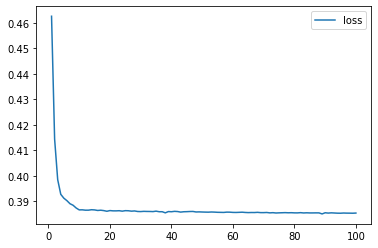

In [51]:
# Create a DataFrame containing training history
history_df = pd.DataFrame(fit_model.history)

# Increase the index by 1 to match the number of epochs
history_df.index += 1

# Plot the loss
history_df.plot(y="loss")

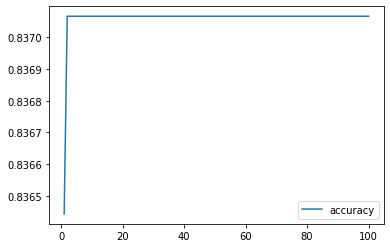

In [52]:
# Plot the accuracy
history_df.plot(y="accuracy")

In [53]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

251/251 - 0s - loss: 0.3926 - accuracy: 0.8411 - 359ms/epoch - 1ms/step
Loss: 0.3925950825214386, Accuracy: 0.8411191701889038


In [68]:
# Create a method that creates a new Sequential model with hyperparameter options
def create_model(hp):
    nn_model = tf.keras.models.Sequential()

    # Allow kerastuner to decide which activation function to use in hidden layers
    activation = hp.Choice('activation',['relu','tanh'])
    
    # Allow kerastuner to decide number of neurons in first layer
    nn_model.add(tf.keras.layers.Dense(units=hp.Int('first_units',
        min_value=1,
        max_value=30,
        step=5), activation=activation, input_dim=1266))

    # Allow kerastuner to decide number of hidden layers and neurons in hidden layers
    for i in range(hp.Int('num_layers', 1, 5)):
        nn_model.add(tf.keras.layers.Dense(units=hp.Int('units_' + str(i),
            min_value=1,
            max_value=30,
            step=5),
            activation=activation))
    
    nn_model.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

    # Compile the model
    nn_model.compile(loss="binary_crossentropy", optimizer='adam', metrics=["accuracy"])
    
    return nn_model

In [64]:
pip install keras-tuner --upgrade

     |████████████████████████████████| 98 kB 3.4 MB/s 


In [65]:
import keras_tuner as kt
from tensorflow import keras

In [69]:
tuner = kt.Hyperband(
    create_model,
    objective="val_accuracy",
    max_epochs=20,
    hyperband_iterations=2) 

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json


In [70]:
# Run the kerastuner search for best hyperparameters
tuner.search(X_train_scaled,y_train,epochs=20,validation_data=(X_test_scaled,y_test))

Trial 61 Complete [00h 01m 22s]
val_accuracy: 0.8412440419197083

Best val_accuracy So Far: 0.841993510723114
Total elapsed time: 00h 25m 24s
INFO:tensorflow:Oracle triggered exit


In [71]:
# Get best model hyperparameters
best_hyper = tuner.get_best_hyperparameters(1)[0]
best_hyper.values

{'activation': 'tanh',
 'first_units': 6,
 'num_layers': 1,
 'tuner/bracket': 2,
 'tuner/epochs': 3,
 'tuner/initial_epoch': 0,
 'tuner/round': 0,
 'units_0': 21,
 'units_1': 6,
 'units_2': 26,
 'units_3': 21,
 'units_4': 11}

In [73]:
# Evaluate best model against full test data
best_model = tuner.get_best_models(1)[0]
model_loss, model_accuracy = best_model.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

251/251 - 0s - loss: 0.3861 - accuracy: 0.8420 - 486ms/epoch - 2ms/step
Loss: 0.3861067295074463, Accuracy: 0.841993510723114
